In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

import itertools

import pandas as pd
from scipy.io import savemat, loadmat
import seaborn as sns
from sklearn.metrics import (log_loss, mean_squared_error, roc_curve, auc,
                             precision_recall_fscore_support, confusion_matrix)
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

from BEKML import BEMKL, poly_kernel, gauss_kernel, scoring


def plot_classification_report(y_test, y_pred, ax=None):
    if ax is None:
        ax = plt.figure(figsize=(8, 8)).gca()

    xticks = ['precision', 'recall', 'f1-score', 'support']
    yticks = list(np.unique(y_test))
    yticks += ['avg']

    rep = np.array(precision_recall_fscore_support(y_test, y_pred)).T
    avg = np.mean(rep, axis=0)
    avg[-1] = np.sum(rep[:, -1])
    rep = np.insert(rep, rep.shape[0], avg, axis=0)

    sns.heatmap(rep,
                annot=True, 
                cbar=False, 
                xticklabels=xticks, 
                yticklabels=yticks,
                ax=ax)
    return


def plot_rocauc(y_test, y_score, ax=None):
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    if ax is None:
        ax = plt.figure(figsize=(8, 8)).gca()
    lw = 2
    ax.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    ax.legend(loc="lower right")
    return


def plot_confusion_matrix(y_test, y_pred, normalize=True,
                          cmap=plt.cm.Blues, ax=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = confusion_matrix(y_test, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    classes = [-1, 1]
    if ax is None:
        ax = plt.figure(figsize=(8, 8)).gca()

    ax_pos = ax.get_position()
    cbar_pos = [ax_pos.x0 + ax_pos.width - ax_pos.width*0.1,
                ax_pos.y0 + ax_pos.height*0.05,
                ax_pos.width*0.05,
                ax_pos.height - ax_pos.height*0.1]
    fig = ax.figure
    cax = fig.add_axes(cbar_pos)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    fig.colorbar(im, cax=cax, orientation='vertical')
    
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(classes, rotation=45)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    return


def plot_metrics(y_true, y_pred, y_scores, axes=None):
    if axes is None:
        _, axes = plt.subplots(3, 1)
    ax1, ax2, ax3 = axes.flatten()
    plot_classification_report(y_test, y_pred, ax=ax1)
    plot_confusion_matrix(y_test, y_pred, ax=ax2)
    plot_rocauc(y_test, y_scores, ax=ax3)


sns.set(style='ticks', context='talk')
np.set_printoptions(precision=4, linewidth=100)

Populating the interactive namespace from numpy and matplotlib


In [2]:
data = pd.read_csv('data/breast.csv', names=list(range(11)), index_col=0, na_values='?')
display(data.describe())
data = data.dropna()
display(data.head())
data.describe()

,1,2,3,4,5,6,7,8,9,10
count,699.000000,699.000000,699.000000,699.000000,699.000000,683.000000,699.000000,699.000000,699.000000,699.000000
mean,4.417740,3.134478,3.207439,2.806867,3.216023,3.544656,3.437768,2.866953,1.589413,2.689557
std,2.815741,3.051459,2.971913,2.855379,2.214300,3.643857,2.438364,3.053634,1.715078,0.951273
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
25%,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000
50%,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000,2.000000
75%,6.000000,5.000000,5.000000,4.000000,4.000000,6.000000,5.000000,4.000000,1.000000,4.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000


,1,2,3,4,5,6,7,8,9,10
0,,,,,,,,,,
1000025,5,1,1,1,2,1.0,3,1,1,2
1002945,5,4,4,5,7,10.0,3,2,1,2
1015425,3,1,1,1,2,2.0,3,1,1,2
1016277,6,8,8,1,3,4.0,3,7,1,2
1017023,4,1,1,3,2,1.0,3,1,1,2


,1,2,3,4,5,6,7,8,9,10
count,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000
mean,4.442167,3.150805,3.215227,2.830161,3.234261,3.544656,3.445095,2.869693,1.603221,2.699854
std,2.820761,3.065145,2.988581,2.864562,2.223085,3.643857,2.449697,3.052666,1.732674,0.954592
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
25%,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000
50%,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000,2.000000
75%,6.000000,5.000000,5.000000,4.000000,4.000000,6.000000,5.000000,4.000000,1.000000,4.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000


In [3]:
X = data.iloc[:, :-1].values.copy()
y = data.iloc[:, -1].values.copy()
N, D = X.shape
y[y == 2] = -1
y[y == 4] = 1
display(X.shape, y.shape, y.mean())

(683, 9)

(683,)

-0.3001464128843338

In [4]:
kernels = [lambda A, B: gauss_kernel(A, B, 2**i) for i in range(-3, 7)]
kernels += [lambda A, B: poly_kernel(A, B, 0, i) for i in range(1, 4)]
kernels += [lambda A, B: gauss_kernel(A[:, j:j+1], B[:, j:j+1], 2**i) for i in range(-3, 7) for j in range(D)]
kernels += [lambda A, B: poly_kernel(A[:, j:j+1], B[:, j:j+1], 0, i) for i in range(1, 4) for j in range(D)]
len(kernels)

130

In [5]:
X_train, X_test, y_train, y_test =\
        train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)

In [6]:
sparse_model = BEMKL(kernels=kernels, alpha_lambda=1, beta_lambda=1, alpha_gamma=1,
                     beta_gamma=1, alpha_omega=1e-11, beta_omega=1e+9, null_threshold=1e-3)
normalizer = Normalizer()
sparse_pipeline = make_pipeline(normalizer, sparse_model)
sparse_pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('normalizer', Normalizer(copy=True, norm='l2')), ('bemkl', BEMKL(alpha_gamma=1, alpha_lambda=1, alpha_omega=1e-11, beta_gamma=1,
   beta_lambda=1, beta_omega=1000000000.0,
   kernels=[<function <listcomp>.<lambda> at 0x7faf801159d8>, <function <listcomp>.<lambda> at 0x7faf80115a60>, <functio...   margin=1, max_iter=200, null_threshold=0.001, random_state=None,
   sigma_g=0.1, verbose=False))])

In [7]:
X_train_norm = normalizer.transform(X_train)
X_test_norm = normalizer.transform(X_test)
Km_train, Km_norms = sparse_model._create_kernel_matrix(X_train_norm, X_train_norm)
Km_test, _ = sparse_model._create_kernel_matrix(X_test_norm, X_train_norm, Km_norms)

In [8]:
savemat('Km.mat', {
    'Km_train': Km_train.transpose(1, 2, 0),
    'y_train': y_train,
    'Km_test': Km_test.transpose(2, 1, 0),
    'y_test': y_test
})

In [9]:
predictions_mat = loadmat('prediction.mat')['prediction'][0, 0]
(predictions_mat['G']['mu'][0, 0].shape, predictions_mat['G']['sigma'][0, 0].shape,
 predictions_mat['f']['mu'][0, 0].shape, predictions_mat['f']['sigma'][0, 0].shape,
 predictions_mat['p'].shape)

((130, 205), (130, 205), (205, 1), (205, 1), (205, 1))

In [10]:
y_pred_proba = sparse_pipeline.predict_proba(X_test_norm)
y_pred = sparse_pipeline.predict(X_test_norm)
y_pred_proba.shape, y_pred.shape

((205, 2), (205,))

In [11]:
display(log_loss(y_test, predictions_mat['p']),
        log_loss(y_test, y_pred_proba))
display(mean_squared_error(y_pred_proba[:, 1].flatten(), predictions_mat['p'].flatten()))

8.2268913117259235

5.6412848033923026

0.51108662630216661

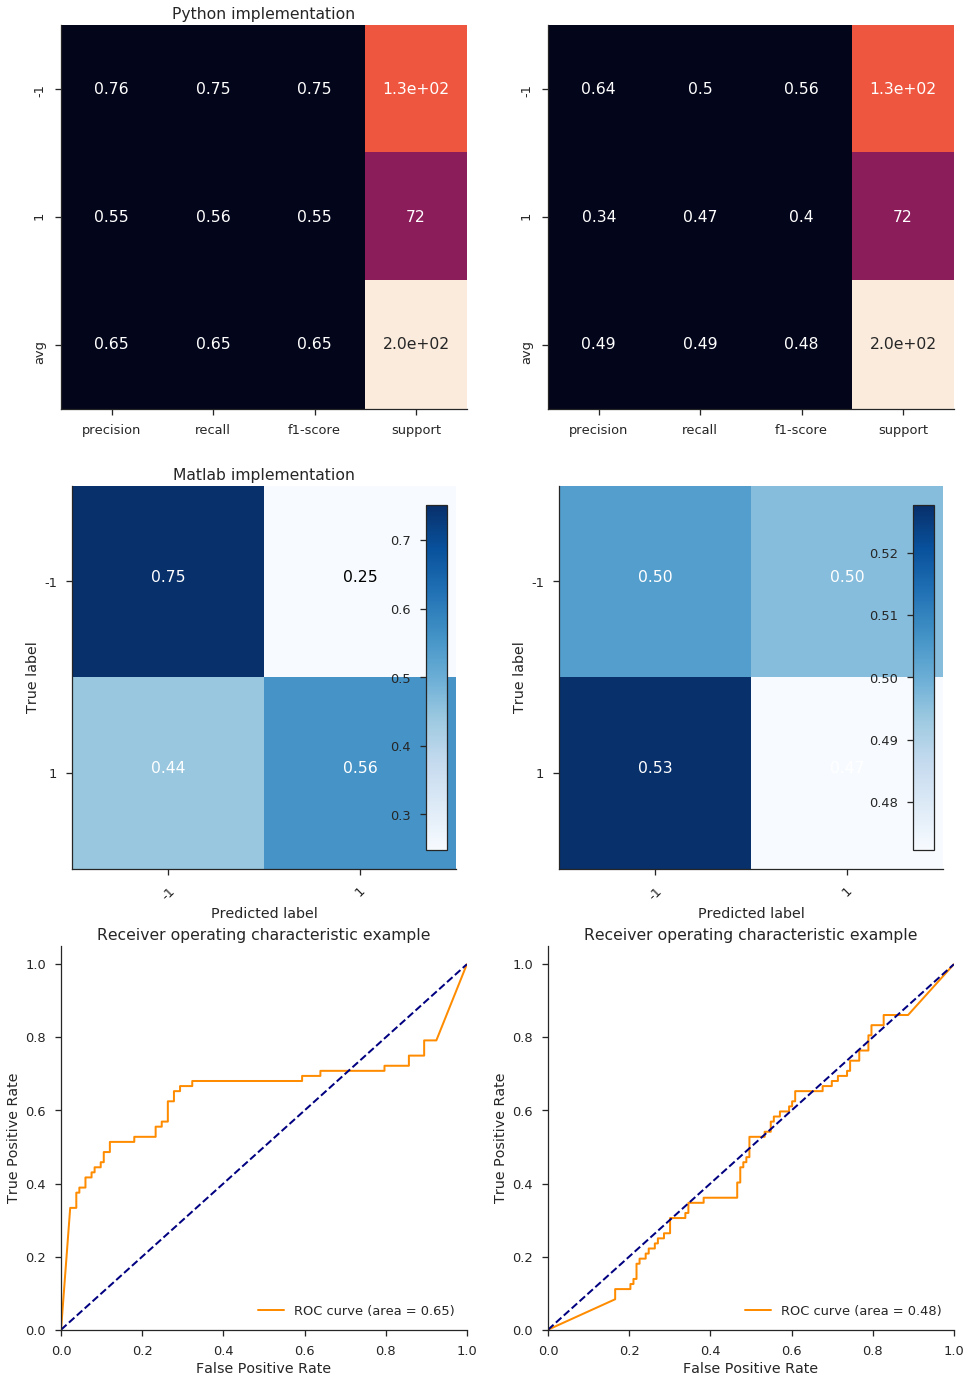

In [12]:
_, axes = plt.subplots(3, 2, figsize=(16, 24))
axes1, axes2 = axes.T

plot_metrics(y_test, y_pred, y_pred_proba[:, 1], axes=axes1)

y_pred_proba_mat = predictions_mat['p']
y_pred_mat = np.ones_like(y_pred_proba_mat)
y_pred_mat[y_pred_proba_mat < 0.5] = -1
plot_metrics(y_test, y_pred_mat, y_pred_proba_mat, axes=axes2)

axes1[0].set_title('Python implementation')
axes1[1].set_title('Matlab implementation')
sns.despine()